In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [3]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [4]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 71, dtype: int64

In [6]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [7]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [8]:
corrdf = df.drop(columns=['datetime']).corr()

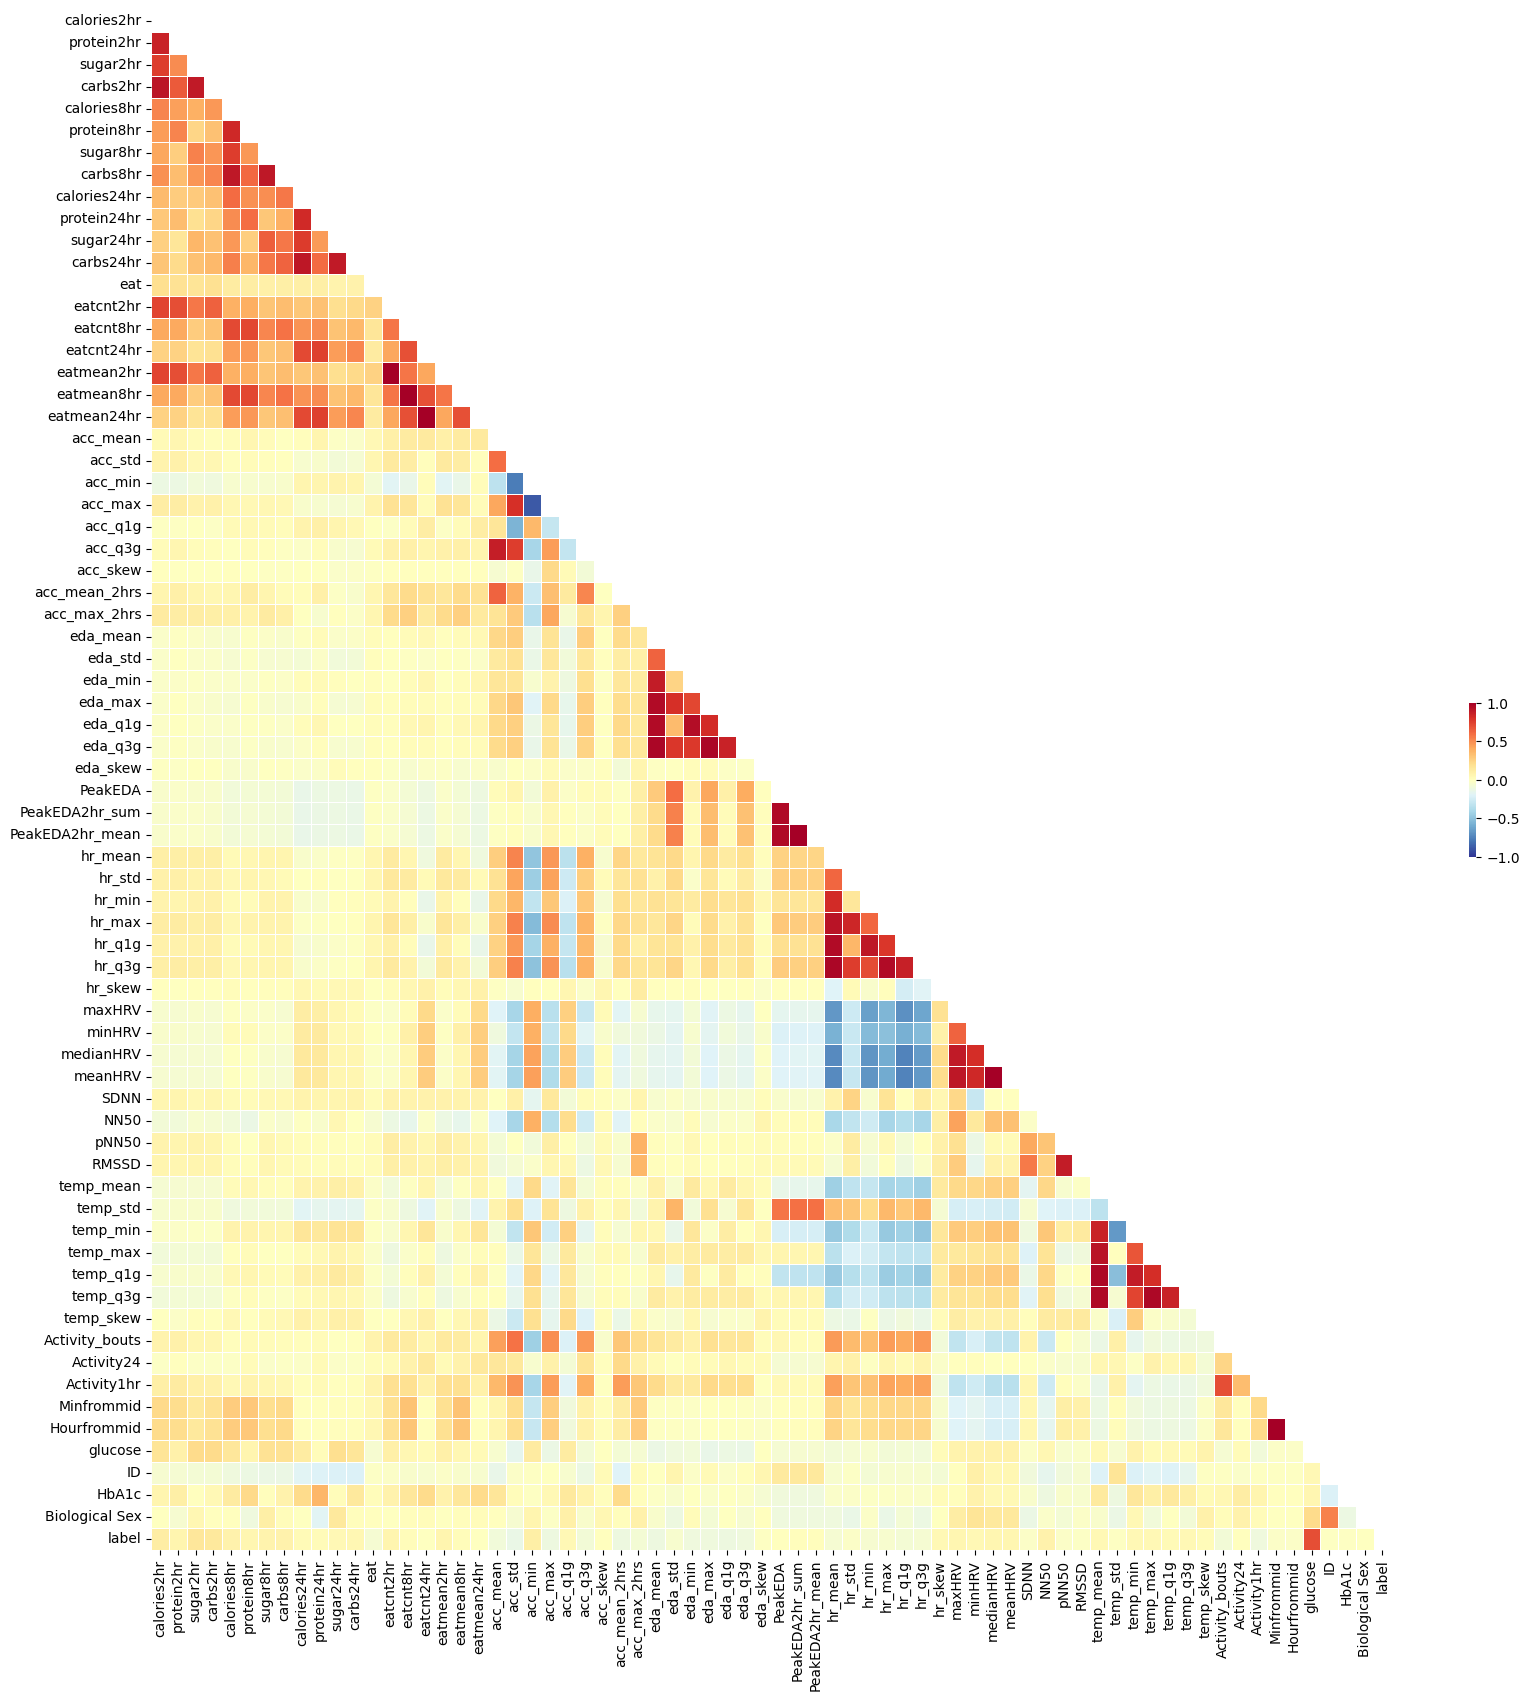

In [9]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation Random forest lgbm_regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [28]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvreg function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    # Instantiate LightGBM model
    lgbm_reg = LGBMRegressor(importance_type='gain')
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    lgbm_reg.fit(X_train, y_train)
    
    # Get importances:
    importances = list(lgbm_reg.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def LGBMLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features 
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here


    lgbm_reg = LGBMRegressor(importance_type='gain')# Train the model on training data
    print('Now processing... LGBMLOOCV')
    lgbm_reg.fit(X_train, y_train)
    
    # Use the LightGBM predict method on the test data
    predictions = lgbm_reg.predict(X_test)
    errors = abs(predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(lgbm_reg.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return errors, RMSE, MAPerror, important, listimportances[listimportances['importances'] >= fs]

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    filtered_importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        er, rm, ma, imp, filteredimp = LGBMLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        importances = pd.concat([importances, imp], ignore_index=True)
        filtered_importances = pd.concat([filtered_importances, filteredimp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return errors, meanrmse, stdrmse, meanmape, stdmape, importances, filtered_importances

In [31]:
errors, RMSE, RMSEstd, MAPE, MAPEstd, importances, filtered_importances = loocvLGBMRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], fs=1.0 * 1e6)

IDlist : ['10.0', '16.0', '1.0', '15.0', '3.0', '5.0', '9.0', '11.0', '13.0', '4.0', '12.0', '14.0', '8.0', '6.0', '2.0']
28203
1858
Now processing... LOOCV_featureselection
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13851
[LightGBM] [Info] Number of data points in the train set: 28203, number of used features: 67
[LightGBM] [Info] Start training from score 116.359253
LOOCV_O : 10.0
Now processing... LGBMLOOCV
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2209
[LightGBM] [Info] Number of data points in the train set: 28203, number of used features: 11
[LightGBM] [Info] Start training from score 116.359253


C:\Users\smyie\AppData\Local\Temp\ipykernel_17524\2398097835.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importances = pd.concat([importances, imp], ignore_index=True)
C:\Users\smyie\AppData\Local\Temp\ipykernel_17524\2398097835.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_importances = pd.concat([filtered_importances, filteredimp], ignore_index=True)


...10.0 processing complete.
28198
1863
Now processing... LOOCV_featureselection
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13876
[LightGBM] [Info] Number of data points in the train set: 28198, number of used features: 67
[LightGBM] [Info] Start training from score 116.788637
LOOCV_O : 16.0
Now processing... LGBMLOOCV
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 28198, number of used features: 10
[LightGBM] [Info] Start training from score 116.788637
...16.0 processing complete.
27789
2272
Now processing... LOOCV_featureselection
[LightGBM] [Info] Auto-choosing col-wise m

In [36]:
print(importances)

              value   importances    id
0          sugar2hr  3.915427e+06  10.0
1          carbs2hr  3.579850e+06  10.0
2        protein8hr  4.163065e+06  10.0
3          carbs8hr  5.320442e+06  10.0
4         sugar24hr  4.777389e+06  10.0
..              ...           ...   ...
150  PeakEDA2hr_sum  4.491427e+06   2.0
151      Activity24  5.951966e+06   2.0
152      Minfrommid  8.637524e+06   2.0
153           HbA1c  4.841530e+06   2.0
154  Biological Sex  2.585421e+06   2.0

[155 rows x 3 columns]


plot filtered_importances

                 importances
value                       
Minfrommid      9.227024e+06
Activity24      6.094418e+06
sugar24hr       5.661884e+06
HbA1c           5.636197e+06
sugar8hr        5.479212e+06
carbs8hr        5.373430e+06
protein24hr     5.050048e+06
carbs2hr        4.913341e+06
acc_max_2hrs    4.803615e+06
protein8hr      4.671987e+06
PeakEDA2hr_sum  4.379568e+06
acc_mean_2hrs   4.237505e+06
calories8hr     4.079646e+06
sugar2hr        4.029126e+06
Biological Sex  3.467548e+06


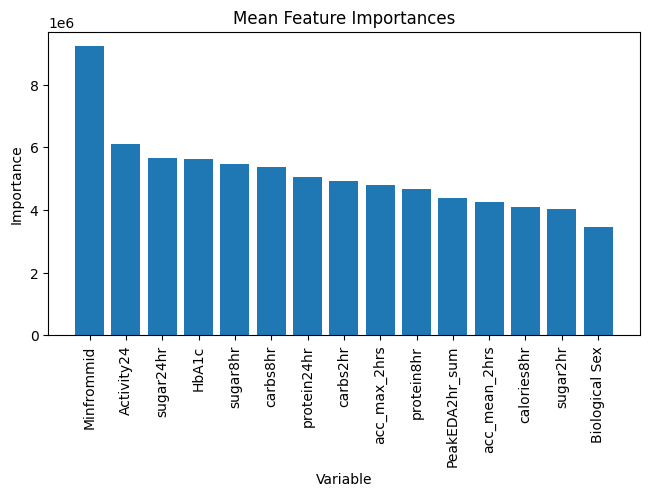

In [38]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
print(filteredimp)
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()